# Predicción de Mercados usando Tensorflow

### Import de librerías

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from datetime import datetime

### Import de los datos

In [36]:
data = pd.read_csv('./stocks/TSLA_5yr.csv')
print(data.shape)
print(data.sample(7))

data['Date'] = pd.to_datetime(data['Date'])

(1259, 7)
            Date        Open        High         Low       Close   Adj Close  \
464   2020-03-18   25.933332   26.990667   23.367332   24.081333   24.081333   
936   2022-01-31  290.903320  312.663330  287.350006  312.239990  312.239990   
898   2021-12-06  333.836670  340.546661  316.833344  336.336670  336.336670   
1146  2022-11-30  182.429993  194.759995  180.630005  194.699997  194.699997   
556   2020-07-29  100.066666  102.320663   99.133331   99.940666   99.940666   
162   2019-01-04   20.400000   21.200001   20.181999   21.179333   21.179333   
330   2019-09-05   14.833333   15.320000   14.723333   15.305333   15.305333   

         Volume  
464   356793000  
936   104436000  
898    81663000  
1146  109186400  
556   141403500  
162   110911500  
330   110929500  


### Mostramos las velas diarias

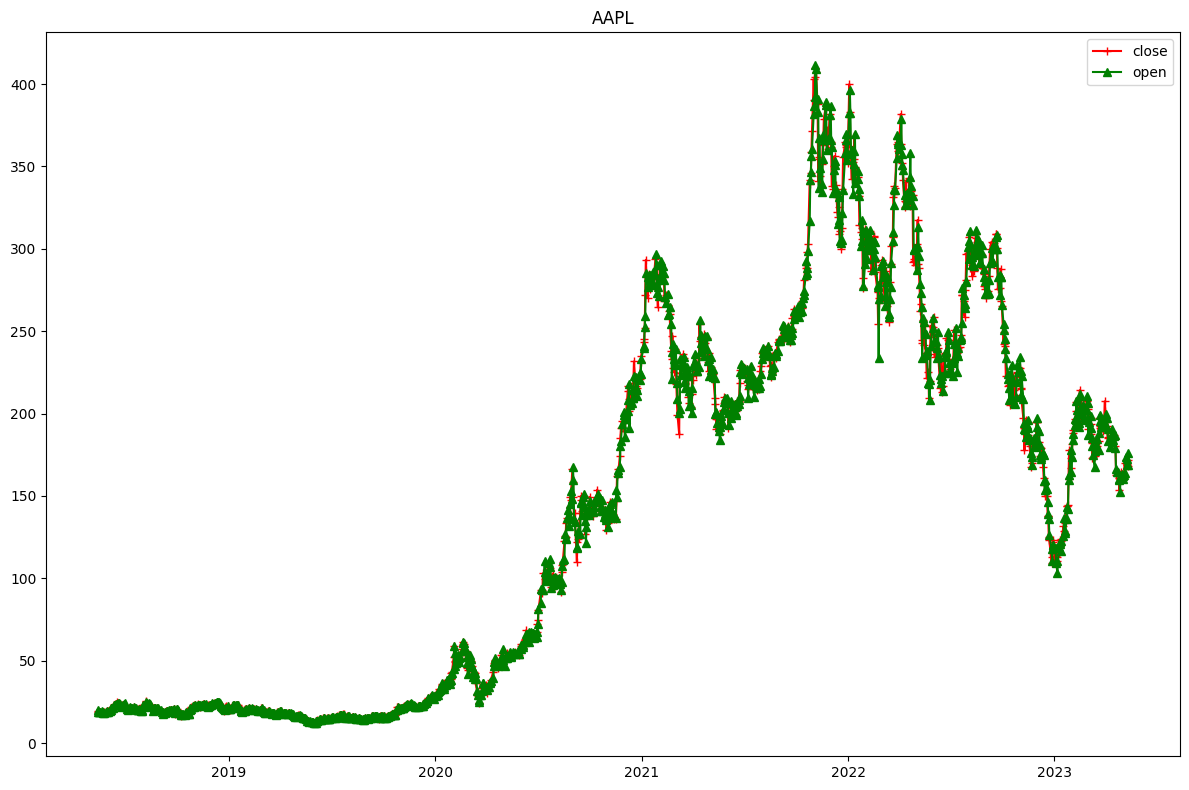

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Close'], c="r", label="close", marker="+")
plt.plot(data['Date'], data['Open'], c="g", label="open", marker="^")
plt.title("AAPL")
plt.legend()
plt.tight_layout()

### Mostramos el volumen diario

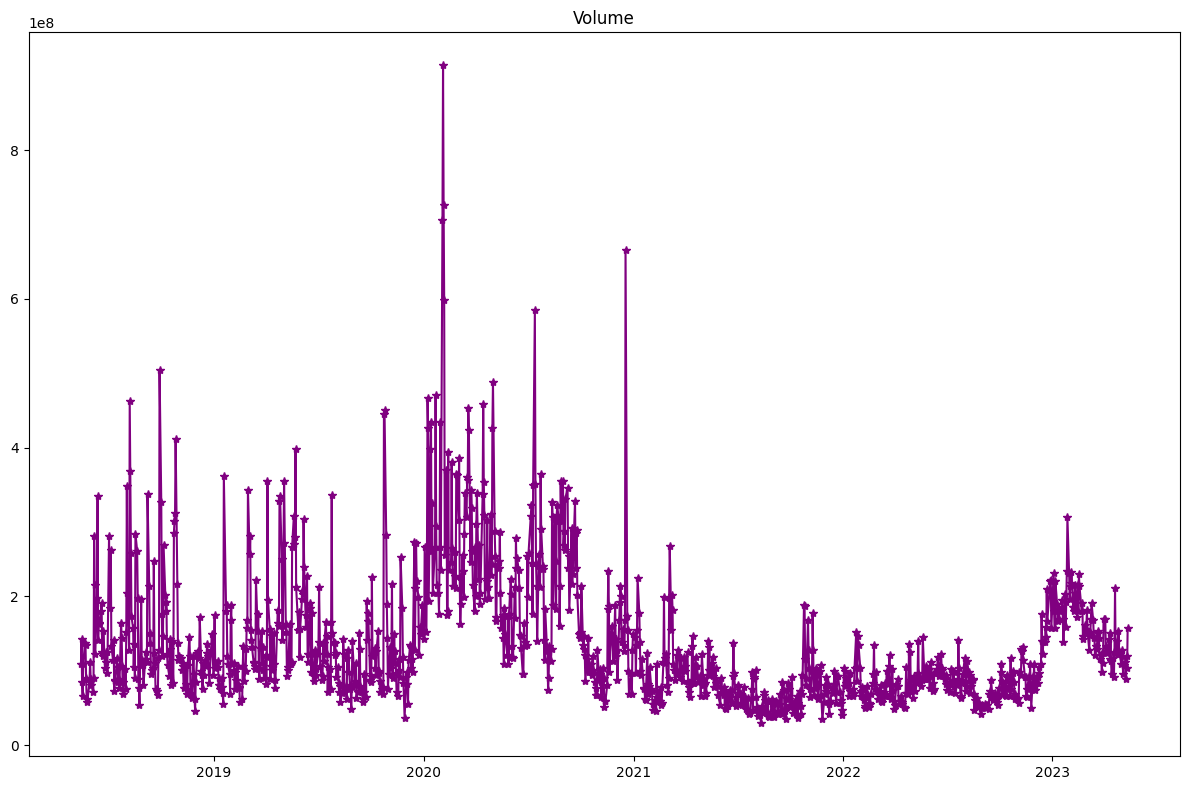

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Volume'], c='purple', marker='*')
plt.title("Volume")
plt.tight_layout()

### Mostramos los datos de entreno

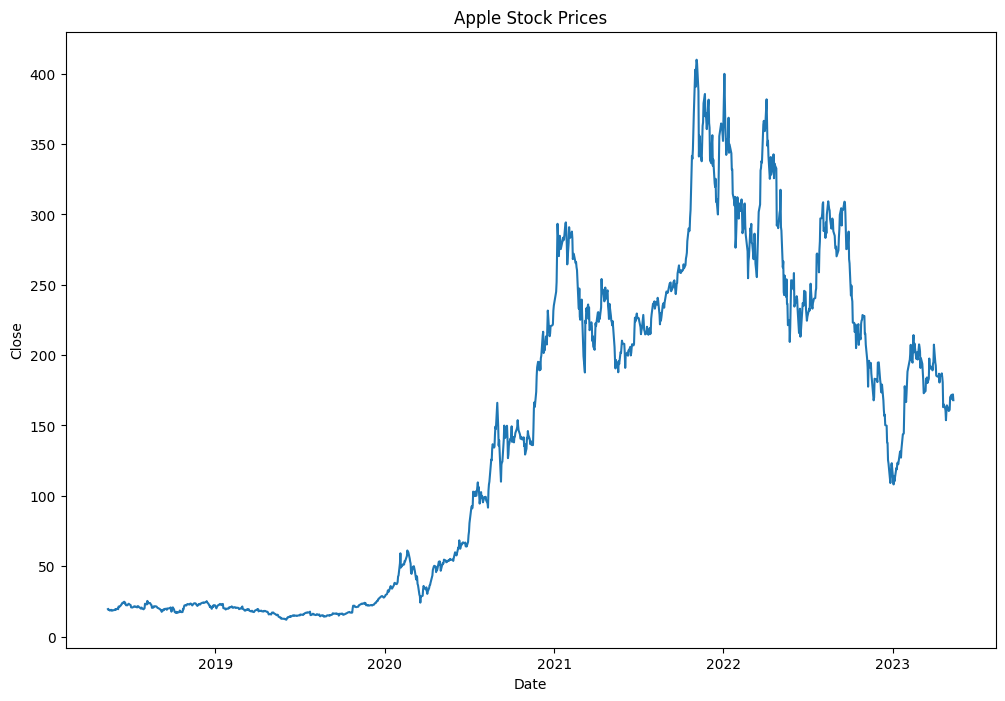

In [39]:
prediction_range = data.loc[(data['Date'] > datetime(2018,5,14)) & (data['Date'] < datetime(2023,5,14))]
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()

### Establecemos el set de entrenamiento y otro para la validación (95%/5%)

In [40]:
close_data = data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
testing = int(np.floor(len(dataset) * .05))
print(training)
print(testing)

1197
62


### Preparamos los datos para el entrenamiento

In [41]:
from sklearn.preprocessing import MinMaxScaler
  
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
  
train_data = scaled_data[0:int(training), :]

x_train = []
y_train = []
  
for i in range(testing, len(train_data)):
    x_train.append(train_data[i - testing:i, 0])
    y_train.append(train_data[i, 0])
  
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Preparamos el modelo

In [42]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 62, 64)            16896     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________


2023-05-14 23:31:43.968301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 23:31:43.970159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 23:31:43.971821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

### Procedemos a entrenar el modelo

In [43]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    verbose=1)

Epoch 1/10


2023-05-14 23:31:44.416118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 23:31:44.418122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 23:31:44.419302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

36/36 [==============================] - 4s 45ms/step - loss: 0.0266
Epoch 2/10
36/36 [==============================] - 1s 40ms/step - loss: 0.0111
Epoch 3/10
36/36 [==============================] - 2s 47ms/step - loss: 0.0084
Epoch 4/10
36/36 [==============================] - 2s 46ms/step - loss: 0.0084
Epoch 5/10
36/36 [==============================] - 2s 51ms/step - loss: 0.0085
Epoch 6/10
36/36 [==============================] - 2s 42ms/step - loss: 0.0070
Epoch 7/10
36/36 [==============================] - 2s 43ms/step - loss: 0.0074
Epoch 8/10
36/36 [==============================] - 2s 44ms/step - loss: 0.0064
Epoch 9/10
36/36 [==============================] - 2s 50ms/step - loss: 0.0063
Epoch 10/10
36/36 [==============================] - 2s 46ms/step - loss: 0.0067


### Establecemos los datos de prueba, generamos la predicción y los MSE

In [44]:
test_data = scaled_data[training - testing:, :]

x_test = []
y_test = dataset[training:, :]
for i in range(testing, len(test_data)):
    x_test.append(test_data[i-testing:i, 0])
  
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  
# prediccion de los datos de prueba
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
  
# metricas MSE (Error Cuadrático Medio) y RMSE (Raiz del Error Cuadrático Medio)
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2023-05-14 23:32:02.853274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 23:32:02.855141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 23:32:02.856294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 17ms/step
MSE 183.38498490660203
RMSE 13.541971234152067


### Mostramos el resultado final con la predicción, entrenamiento y pruebas

/tmp/ipykernel_3373/1080195945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


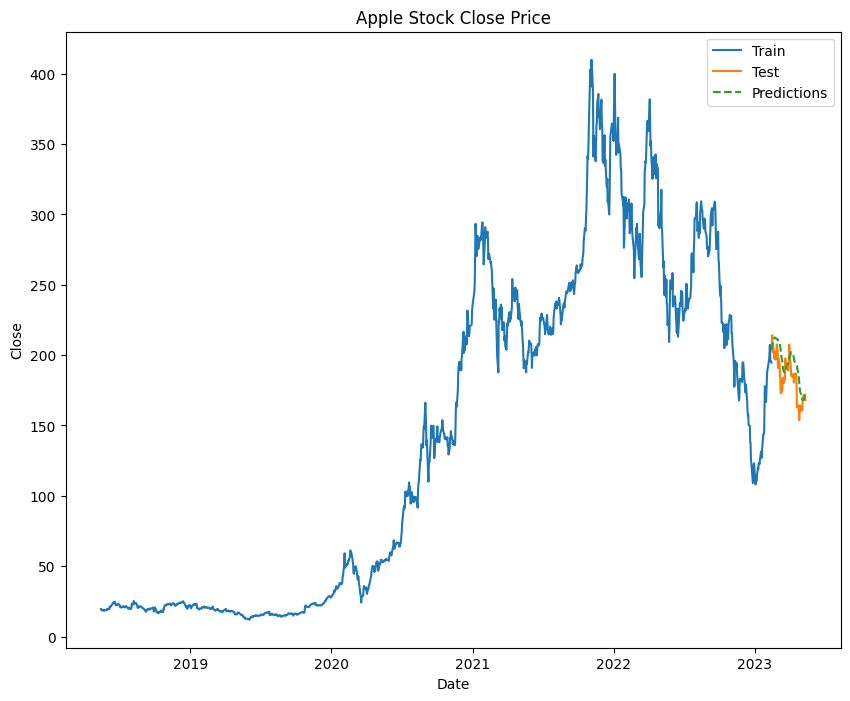

In [45]:
train = data[:training]
test = data[training:]
test['Predictions'] = predictions
  
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test['Close'])
plt.plot(test['Date'], test['Predictions'], linestyle='dashed')
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
# plt.axis([2022,2023,120,180])